In [1]:
# Step 0. Import libraries and custom modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
# Preprocessing --------------------------------------------------------
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Metrics --------------------------------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Exporting ------------------------------------------------------------
import pickle


In [2]:
# Step 1. Read the dataset
# The data this week comes from Coffee Quality Database courtesy of Buzzfeed Data Scientist 
# James LeDoux. The original data can be found on James' github. The data was re-posted to Kaggle.
# These data were collected from the Coffee Quality Institute's review pages in January 2018.
# There is data for both Arabica and Robusta beans, across many countries and professionally 
# rated on a 0-100 scale. All sorts of scoring/ratings for things like acidity, sweetness, fragrance, 
# balance, etc - may be useful for either separating into visualizations/categories or for 
# modeling/recommenders.
# https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-07-07/readme.md
url = 'https://raw.githubusercontent.com/rfordatascience/' + \
'tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv'
df_raw = pd.read_csv(url)
df_raw.to_csv('../data/raw/coffee.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_cup_points       1339 non-null   float64
 1   species                1339 non-null   object 
 2   owner                  1332 non-null   object 
 3   country_of_origin      1338 non-null   object 
 4   farm_name              980 non-null    object 
 5   lot_number             276 non-null    object 
 6   mill                   1021 non-null   object 
 7   ico_number             1180 non-null   object 
 8   company                1130 non-null   object 
 9   altitude               1113 non-null   object 
 10  region                 1280 non-null   object 
 11  producer               1107 non-null   object 
 12  number_of_bags         1339 non-null   int64  
 13  bag_weight             1339 non-null   object 
 14  in_country_partner     1339 non-null   object 
 15  harv

In [3]:
df_raw.sample(10)

,total_cup_points,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,...,color,category_two_defects,expiration,certification_body,certification_address,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
407,83.33,Arabica,dane loraas,Peru,NaN,NaN,NaN,030-0695-1742,sustainable harvest,NaN,...,Green,5,"January 21st, 2015",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,NaN,NaN,NaN
348,83.58,Arabica,alfredo bojalil,Mexico,ojo de agua,NaN,agroindustrias unidas de mexico,2222,ecomtrading,1000,...,NaN,2,"June 6th, 2013",AMECAFE,59e396ad6e22a1c22b248f958e1da2bd8af85272,0eb4ee5b3f47b20b049548a2fd1e7d4a2b70d0a7,m,1000.00,1000.00,1000.00
51,86.00,Arabica,grounds for health admin,United States (Hawaii),hula daddy kona coffee,NaN,NaN,NaN,NaN,1400ft,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,426.72,426.72,426.72
879,81.67,Arabica,tembo coffee company ltd,"Tanzania, United Republic Of",ilomba 1,NaN,tembo coffee company ltd,C39,tembo coffee company ltd,1700,...,Green,7,"December 15th, 2015",Africa Fine Coffee Association,073285c0d45e2f5539012d969937e529564fa6fe,c4ab13415cdd69376a93780c0166e7b1a10481ea,m,1700.00,1700.00,1700.00
355,83.50,Arabica,juan luis alvarado romero,Guatemala,la esperanza,11/23/0145,beneficio ixchel,11/23/0145,"unex guatemala, s.a.",4000,...,Bluish-Green,5,"March 16th, 2017",Asociacion Nacional Del Café,b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53,724f04ad10ed31dbb9d260f0dfd221ba48be8a95,ft,1219.20,1219.20,1219.20
1076,80.50,Arabica,eileen koyanagi,United States (Hawaii),NaN,NaN,NaN,KP010914,kona pacific farmers cooperative,NaN,...,Green,0,"February 4th, 2015",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
777,82.08,Arabica,sanjava coffee,Indonesia,various,SRAN-Gayo,bener meriah - gayo,NaN,pt. shriya artha nusantara,1300,...,NaN,3,"August 3rd, 2018",Specialty Coffee Association of Indonesia,99fa73db21b7acd9c9ceb9dd84e409d2077d55c4,36910838db193ebdd61fa1427bac74622114c49a,m,1300.00,1300.00,1300.00
666,82.50,Arabica,saul m. hernandez ramirez,Mexico,la pagua,NaN,el mavodo,1702773555,NaN,1679,...,NaN,10,"September 27th, 2013",AMECAFE,59e396ad6e22a1c22b248f958e1da2bd8af85272,0eb4ee5b3f47b20b049548a2fd1e7d4a2b70d0a7,m,1679.00,1679.00,1679.00
37,86.25,Arabica,kona pacific farmers cooperative,United States (Hawaii),kona pacific farmers cooperative,NaN,NaN,HDOA 210128 Kona Fancy,NaN,NaN,...,NaN,1,"January 28th, 2012",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
1156,79.75,Arabica,montegrande,Mexico,finca monte grande,NaN,NaN,1506622214,cafe montegrande,1100,...,NaN,7,"June 6th, 2013",AMECAFE,59e396ad6e22a1c22b248f958e1da2bd8af85272,0eb4ee5b3f47b20b049548a2fd1e7d4a2b70d0a7,m,1100.00,1100.00,1100.00


In [4]:
# 1.2 Transform data
# Select metrics
df_interim = df_raw.copy()
# Select columns
df_interim = df_interim[['total_cup_points',
                         'species',
                         'country_of_origin',
                         'variety',
                         'aroma',
                         'aftertaste',
                         'acidity',
                         'body',
                         'balance',
                         'sweetness',
                         'altitude_mean_meters',
                         'moisture']]
df_interim = df_interim.dropna()

top_varieties = ['Caturra', 'Typica', 'Bourbon', 'Catuai', 'Yellow Bourbon ']
df_interim.variety = df_interim.variety.apply(lambda x: x if x in top_varieties else 'Other')

top_countries = ['Mexico', 'Guatemala', 'Colombia', 'Brazil', 'Taiwan', 'Honduras', 'Costa Rica', 'Tanzania, United Republic of']
df_interim.country_of_origin = df_interim.country_of_origin.apply(lambda x: x if x in top_countries else 'Other')

df_interim['specialty'] = df_interim.total_cup_points.apply(lambda x: 'Yes' if x > 80 else 'No')

df_interim['variety'] = pd.Categorical(df_interim['variety'])
df_interim['country_of_origin'] = pd.Categorical(df_interim['country_of_origin'])
df_interim['species'] = pd.Categorical(df_interim['species'])
df_interim['specialty'] = pd.Categorical(df_interim['specialty'])
df_interim = df_interim.drop(['total_cup_points'], axis=1)

df_interim.to_csv('../data/interim/coffee_model_interim.csv')
df = df_interim.copy()

In [5]:
# 3. Exploratory Data Analysis (EDA)
# 3.1 Create train and test subsets
X = df.copy().drop(['specialty', 'sweetness', 'altitude_mean_meters', 'species'], axis=1)
y = df['specialty']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2007)

df_train = pd.concat([X_train, y_train], axis=1)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 1178 to 1165
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country_of_origin  747 non-null    category
 1   variety            747 non-null    category
 2   aroma              747 non-null    float64 
 3   aftertaste         747 non-null    float64 
 4   acidity            747 non-null    float64 
 5   body               747 non-null    float64 
 6   balance            747 non-null    float64 
 7   moisture           747 non-null    float64 
 8   specialty          747 non-null    category
dtypes: category(3), float64(6)
memory usage: 43.7 KB


In [7]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country_of_origin,747,8,Mexico,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,747,5,Other,207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aroma,747.0,NaN,NaN,NaN,7.567095,0.28436,6.5,7.42,7.58,7.75,8.75
aftertaste,747.0,NaN,NaN,NaN,7.386399,0.323808,6.17,7.25,7.42,7.58,8.58
acidity,747.0,NaN,NaN,NaN,7.52407,0.301195,5.25,7.33,7.5,7.67,8.58
body,747.0,NaN,NaN,NaN,7.505234,0.265359,6.42,7.33,7.5,7.67,8.42
balance,747.0,NaN,NaN,NaN,7.500857,0.333181,6.08,7.33,7.5,7.67,8.58
moisture,747.0,NaN,NaN,NaN,0.094137,0.044483,0.0,0.1,0.11,0.12,0.17
specialty,747,2,Yes,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN


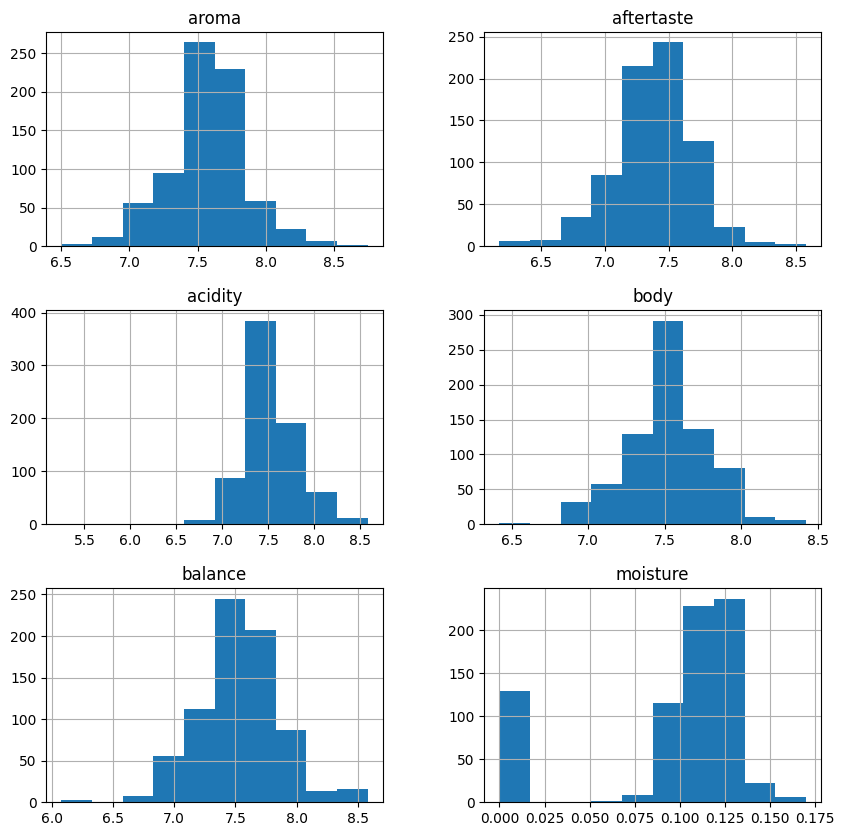

In [8]:
df_train.hist(figsize=(10, 10))
plt.show()

/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


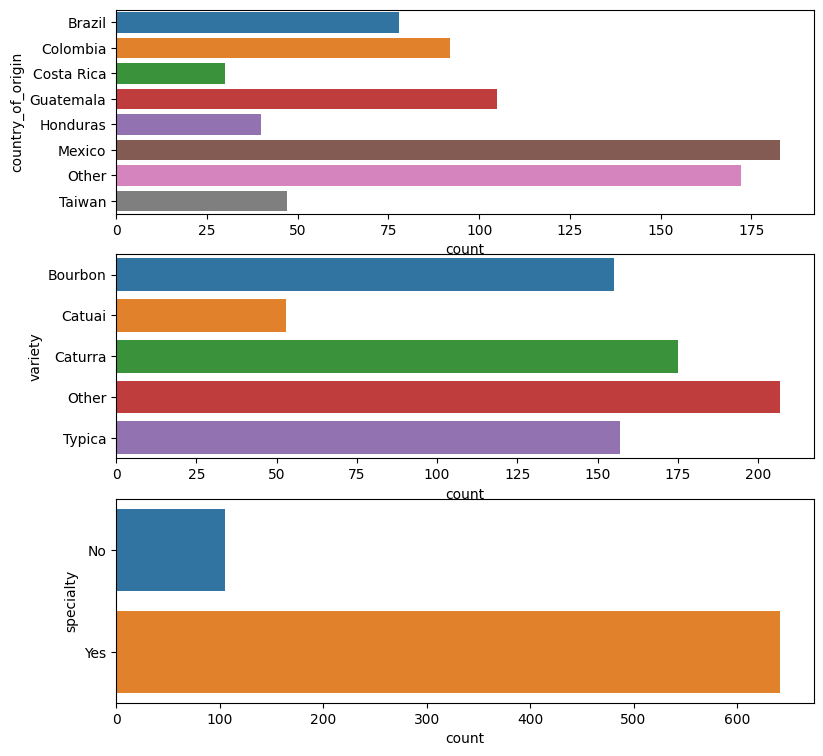

In [9]:
cats = df_train.select_dtypes('category')
fig, ax = plt.subplots(3, 1, figsize=(9, 9))

axs = ax.flatten()

for i in range(len(axs)):
    sns.countplot(data=cats, y=cats.columns.to_list()[i], ax=axs[i])

plt.show()

/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

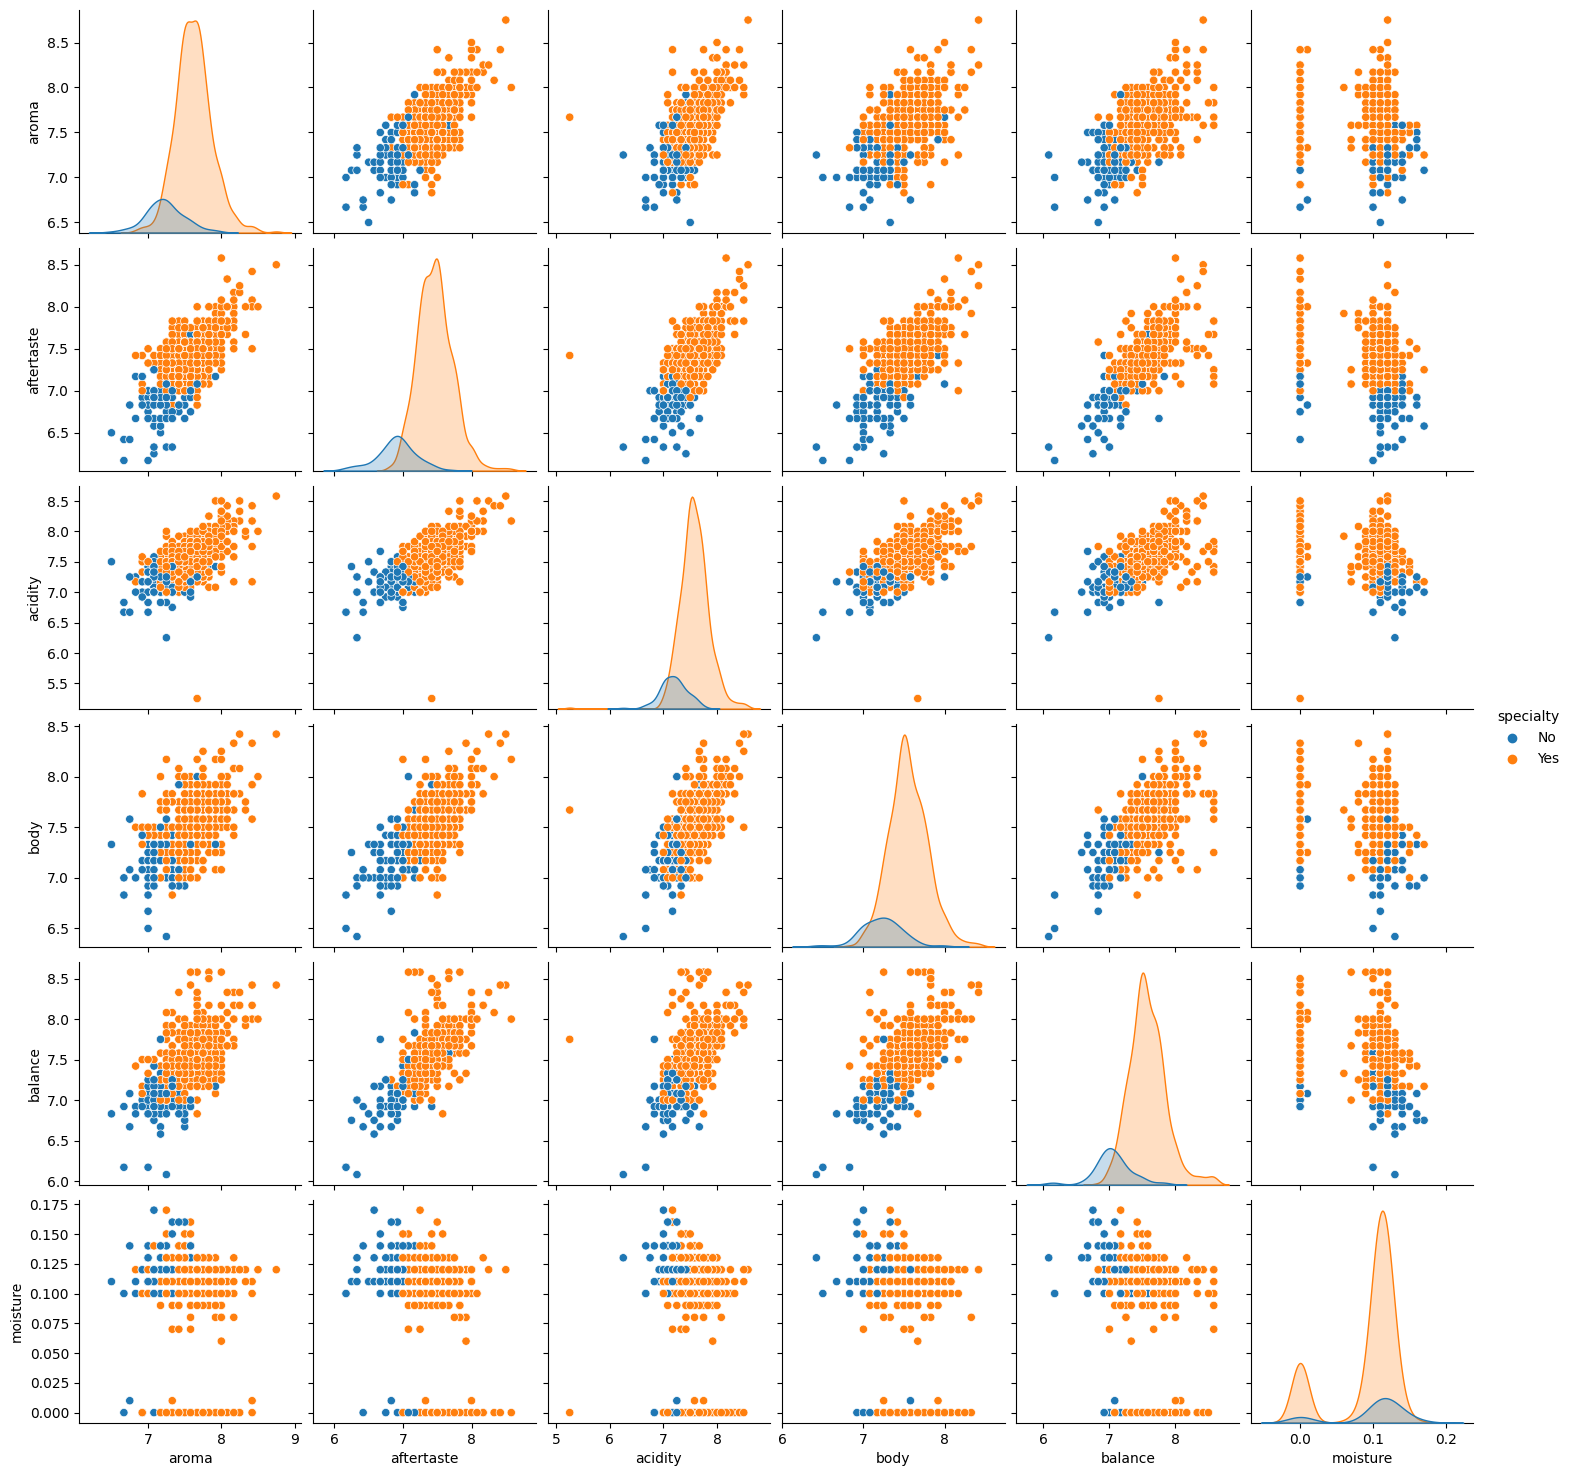

In [10]:
# numerical pairplot analysis

sns.pairplot(data=df_train, hue='specialty')
plt.show()

/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/workspaces/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


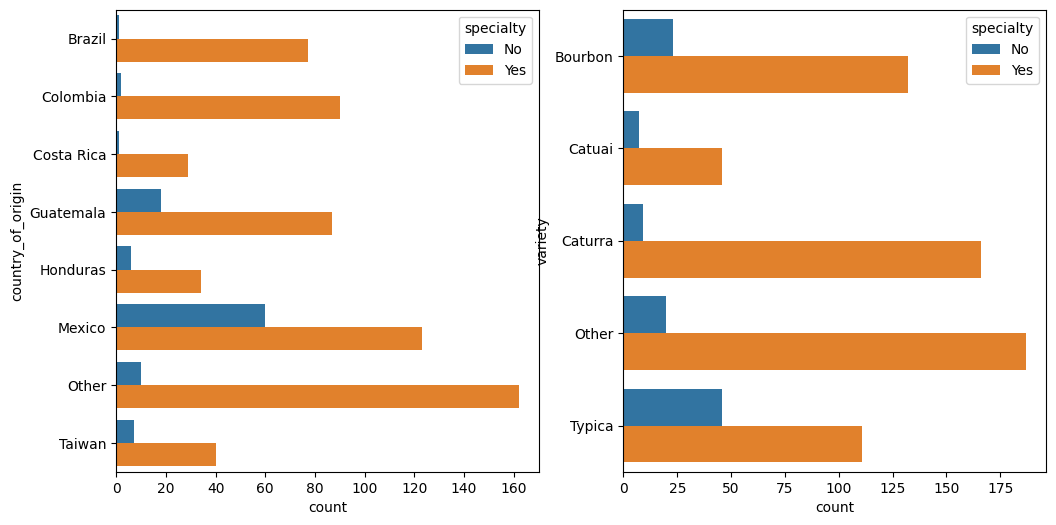

In [11]:
# categorial pairplot analysis

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df_train, y='country_of_origin', hue='specialty', ax=ax[0])
sns.countplot(data=df_train, y='variety', hue='specialty', ax=ax[1])

plt.show()